## **LDA Analysis code**
**Team:** Train derailment in Ohio  
**Members:** Elaine Zhang, Ricardo Ibarra-Gil, Mahrukh Khan 

In [1]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import pandas as pd
# data: 20 news groups

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import random
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pyLDAvis.enable_notebook()
from sklearn.pipeline import make_pipeline

[nltk_data] Downloading package punkt to /Users/ribarragi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data preprocessing

In [2]:
# Read in data
df = pd.read_csv('../data/data_tweet.csv')

# modify default stop words
add_stopwords = set(['rt','train','southern','east','derailment','norfolk','palestine','february','u','ohio', 'amp', '20', 'car', ])
remove_stopwords = set(["no", "not", "nor", "against", "aren't", "couldn't", "didn't", 
                                                   "doesn't", "don't", "haven't", "hadn't", "hasn't", "isn't", "mightn't",
                                                   "mustn't", "needn't", "shouldn't", "wasn't", "weren't", "wouldn't"])
# remove stopwords (not impacting sentiment analysis) and punctuations
stop_words = set(stopwords.words('english')) - remove_stopwords
stop_words = set(stopwords.words('english')).union(add_stopwords)
# stop_words = set(stopwords.words('english')).union(add_stopwords_2)
tokenizer = RegexpTokenizer(r'\w+')


# normalize pos tags
lemmatizer = WordNetLemmatizer()

def pos_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
      return wordnet.ADJ
  elif nltk_tag.startswith('V'):
      return wordnet.VERB
  elif nltk_tag.startswith('N'):
      return wordnet.NOUN
  elif nltk_tag.startswith('R'):
      return wordnet.ADV
  else:         
      return None

# lemmatize each token with pos tag
def lemma_token(row):
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), row))
  lemmatized = []
  for word, tag in wordnet_tagged:
    if tag is None:
        # if there is no available tag, just append the original token
        lemmatized.append(word)
    else:       
        # else use the pos tag to lemmatize the token
        lemmatized.append(lemmatizer.lemmatize(word, tag))
  return lemmatized

# remove urls
df['Message_no_url'] = df['MESSAGE'].apply(lambda x: " ".join([word for word in x.split(" ") if not(word.startswith(("https://", 'http://')))]))


# tokenize MESSAGE and remove stopwords
df['Text'] = df['Message_no_url'].map(tokenizer.tokenize)
df['Text'] = df['Text'].apply(lambda x : nltk.pos_tag([item.lower() for item in x if item.lower() not in stop_words]))

# apply lemmatization and reset index
df['Text'] = df['Text'].apply(lambda row : lemma_token(row))
df = df.reset_index(drop=True)

# join words
df['T_text'] = df['Text'].apply(lambda row : " ".join(row))

In [4]:
# number of documents (tweets) in our data
len(df)

85220

In [5]:
# # We first used a random sample to test this
# sample_size = 10000
# random.seed(1)
# # We will use a random sample of 10k tweets to test
# idx_sample = random.sample(range(len(df.T_text)), sample_size)
# # sample_data is a list of strings, each string is a tweet. ssample_Data is length 10k
# sample_data = [df.T_text[i] for i in idx_sample]
# len(sample_data)

In [6]:
# take only the text
sample_data = df.T_text.tolist()

## Vectorization

We use CountVectorizer to get term frequencies.

In [7]:
# We could cap the size of the vocab to vocab_size
# If not capped, we have 48k words
max_vocabulary = 15000

# We can also set options to only keep words that appear in at least this percentage of documents
# - min_df = 2 # words in less than 2 documents we discard them
# And we can choose to only keep words that appear in at most this percentage of documents:
# - max_df = 0.95 # words that appear in more than 95% of documents, we discard them
# Finally, we can set max_features, to keep only the most frequently occuring words
# - max_features = max_vocabulary # after I do the max_df, min_df and stopwords filetrs, I look at how many words I have left: if its greater than
# max_features, I only keep the most popular. BUT, if the words left after the 3 filters is less than max_features, then it will be ignored. 


# We capped the number of words to 15k and the min doc frequency
tf_vectorizer = CountVectorizer(min_df = 2, max_features=max_vocabulary)

# tf: term frequency vectorizer

# the fitting is learning the vocabulary: goes thru all the data and know the words it needs to keep track of
# transform: Ive done the fitting, Ill go back to data points and convert each one into a feat vector representation using the vocab i learnt during fitting
tf_fit = tf_vectorizer.fit(sample_data)
tf = tf_vectorizer.fit_transform(sample_data)


In [8]:
# size of the matrix (documents, words)
tf.toarray().shape

(85220, 15000)

In [9]:
# seems like the highest term-doc freq is 10
max_freq = tf.toarray().max()
max_freq

10

In [10]:
# which doc / word combination has highest values?
max_freq_idx = list(np.argwhere(tf.toarray()==max_freq)[0])
max_freq_doc, max_freq_word = max_freq_idx
# to print out the vocabulary in the doc-word freq matrix
tf_vectorizer.get_feature_names_out()[max_freq_word]
# In which document is this word?
sample_data[max_freq_doc]

'trump state go trump trump trump trump trump trump trump trump trump'

In [11]:
tf[0].toarray()

# I can index in to the zeroeth row of the matrix and convert into an array, I am anazlizing just the zeroeth row:
# feature vector representation for the zeroeth document: 
# We should be able to write code to know what word corresponds each non zero number there

# tf_vectorizer.get_feature_names_out()[(tf[0].toarray() != 0)[0]] # LIKE THIS!

# run a for loop that goes thru the entries, and check to which indeces this corresponds in the vocabulary

array([[0, 0, 0, ..., 0, 0, 0]])

In [12]:
# Now LDA

num_topics = 4

lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

LatentDirichletAllocation(n_components=4, random_state=0)

In [13]:
lda.components_.shape
# The shaope of this is 4 by 1000, 4 topics and 15000 words

(4, 15000)

In [16]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

# we get the topic-word distribution matrix for the LDA model.  Each value represents the probability of each word occuring in that topic. 
# The higher the value of a word in a topic, the more strongly the word is associated with that topic

In [17]:
topic_word_distributions.shape

(4, 15000)

In [20]:
# We can visualize our results using pyLDAvis
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.134764  0.185574       1        1  33.343986
2     -0.067166 -0.134981       2        1  25.714547
1     -0.075923 -0.084799       3        1  23.515017
3      0.277853  0.034206       4        1  17.426450, topic_info=           Term          Freq         Total Category  logprob  loglift
1124    another   5782.000000   5782.000000  Default  30.0000  30.0000
2437        ceo   4917.000000   4917.000000  Default  29.0000  29.0000
3797     derail   8824.000000   8824.000000  Default  28.0000  28.0000
3810    derails   4289.000000   4289.000000  Default  27.0000  27.0000
13498     toxic  10461.000000  10461.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
9351   official   1282.565328   3199.656576   Topic4  -4.9342   0.8330
1930      break   1106.003223   2164.302785   Topic4  -5.0823   1.0758
8930       near   1052.609101   2147.261108   Topic4  -5.1318   1.0343
8997       news   1126.596367   3459.071855   Topic4  -5.0639   0.6254
10671  railroad   1059.438283   3531.175650   Topic4  -5.1253   0.5433

[320 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
180        1  0.997319            2018
196        4  0.998637             212
590        4  0.997562          aboard
681        2  0.997978        activist
728        1  0.769391  administration
...      ...       ...             ...
14781      4  0.002390           wrong
14882      1  0.831138            year
14882      2  0.118218            year
14882      3  0.050591            year
14882      4  0.000516            year

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [21]:
# We want to know, for each tweet, what fraction is explained by each of the topics
doc_topic_matrix = lda.transform(tf)

In [22]:
doc_topic_matrix.shape

(85220, 4)

In [23]:
sample_data[3]

'nicksortor break state sue explosion aim force railroad pay environmental cleanup economic damage'

**After not getting much from the results of the overall sample using words as token, we splitted the data into govt, media, and public accounts, adn explored with 2 grams.**

In [3]:
data_media = df.query('IS_MEDIA == 1')
data_govt = df.query('IS_GOVT == 1')
data_people = df.query('IS_PEOPLE == 1')

In [4]:
# Created a function that takes the data set, some parameters and outputs the term frequency distribution, vectorizer, the vocabulary, 
# the lda model fitted and the data transformed from dataframe into a list
def parse_lda(dataframe, max_voc, min_df, num_topics):
  '''Outputs the term frequency distribution, vectorizer, the vocabulary, the lda model fitted and the data transformed from dataframe into a list
  Parameters: 
    list_documents:list of strings, contains documents to be analyzed
    max_voc:int, the max size of vocab allowed
    min_df: int, minimum document frequency, i.e., keep words that appear in at least this number of documents
    '''
  sample_data = dataframe.T_text.tolist()
  max_vocabulary = max_voc
  tf_vectorizer = CountVectorizer(min_df = min_df, max_features=max_voc)
  tf_fit = tf_vectorizer.fit(sample_data)
  tf = tf_vectorizer.fit_transform(sample_data)
  lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
  lda.fit(tf)

  return tf, tf_vectorizer, tf_vectorizer.get_feature_names_out(), lda, sample_data

In [54]:
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_media, max_voc = 3800, min_df = 2, num_topics = 4)

In [7]:
# We checked for sparsity

# 1. Sparsity
# How sparse is this document?
# We are taking the non zero entries in the doc-word frequency matrix
# Sparsity (%) = (# of zero elements in tf / total # of elements in tf) x 100
# A good level of sparsity may be 0.2 to 0.8, but it depends on the task performed

sparsity_media = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_media}')

Sparsity: 0.2962036471140043


In [8]:
def most_frequent(tf, vocab, data):
  #highest frequency word
  max_freq = tf.toarray().max()
  # which doc / word combination has highest values?
  max_freq_idx = list(np.argwhere(tf.toarray()==max_freq)[0])
  max_freq_doc, max_freq_word = max_freq_idx
  # to print out the vocabulary in the doc-word freq matrix
  # vocab[max_freq_word]
  # In which document is this word?
  # sample_data[max_freq_doc]
  print(f'The most repeated word in a single tweet is {vocab[max_freq_word]}, and it is repeated {max_freq} times in the tweet: {data[max_freq_doc]}')
  

In [55]:
# Gives us the most frequent word, and the tweets where that appears
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is get, and it is repeated 4 times in the tweet: get rid safety rule get get rid bank safety rule get svb signature


In [56]:
# To create the topic word 
topic_word = np.array([row / row.sum() for row in lda.components_])

In [57]:
topic_word.shape

(4, 3800)

**We want to know first tbe best number of topics for each of the subsamples**

We will use three metrics:
1. Loglikelihood as a measure of how well the model explains the data. In this case, it gives us: given the topics, what is the probability of observing the words in the tweets. We want this metric to be higher  

2. Perplexity is a measure of how well would the model predict terms in unseen tweets. we want low perplexity (low perplexity means that our model would be better at classifying into which topic a new unseen document falls.)  

3. Coherence as a measure of how coherent or interpretable the topics are. what is the degree of similarity between the top words in a topic. We want higher values.  

**Media**

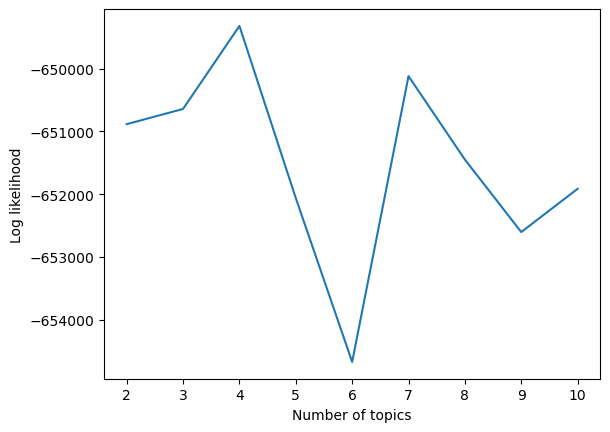

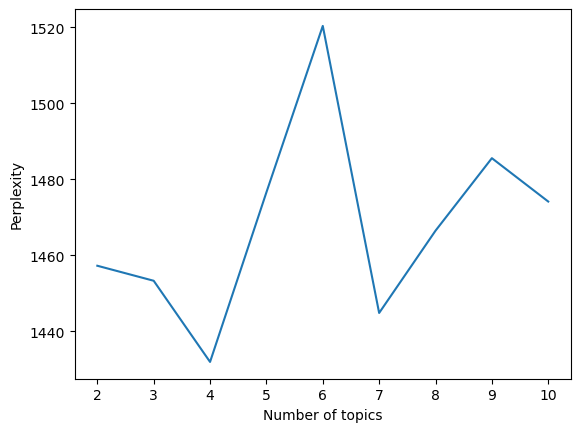

In [59]:
# log likelihood, perplexity
k = 10

text = [i for i in data_media.T_text]

# Tokenize on bigrams
bigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tf = bigram_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in range(2, k+1):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(bigram_tf)
    pipeline = make_pipeline(bigram_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(bigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(bigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

In [ ]:
# We adapted some code from the Unstructured Data Analytics class, taught by Professor George Chen
# for computing the average coherence part of this project.

# Compute coherence
# Sample text
text = [i for i in data_media.T_text]


# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

In [ ]:
# brute force implementation
# nothing clever to speed upmcalculation

#fro loop for each topic
# For loop over each top word
# another for loop for other topics
# lok for all other top words in those other topics
# check for uniqueness

def compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_number_of_unique_top_words = 0
    for topic_idx1 in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx1, ']', sep='')
        
        sort_indices1 = np.argsort(topic_word_distributions[topic_idx1])[::-1]
        num_unique_top_words = 0
        for top_word_idx1 in sort_indices1[:num_top_words]:
            word1 = vocab[top_word_idx1]
            break_ = False
            for topic_idx2 in range(num_topics):
                if topic_idx1 != topic_idx2:
                    sort_indices2 = np.argsort(topic_word_distributions[topic_idx2])[::-1]
                    for top_word_idx2 in sort_indices2[:num_top_words]:
                        word2 = vocab[top_word_idx2]
                        if word1 == word2:
                            break_ = True
                            break
                    if break_:
                        break
            else:
                num_unique_top_words += 1
        if verbose:
            print('Number of unique top words:', num_unique_top_words)
            print()

        average_number_of_unique_top_words += num_unique_top_words
    average_number_of_unique_top_words /= num_topics
    
    if verbose:
        print('Average number of unique top words:', average_number_of_unique_top_words)
    
    return average_number_of_unique_top_words

In [ ]:
def prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (bigram_tokens[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (bigram_tokens[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [ ]:
# topic coherence

def compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_coherence = 0
    # foor loop thru different topics, for each topic double nested for loop, going thru each entry, ordering matters
    # make sure words arent the same, then compute the log(prob)
    # add a bunhc of them and divide by total number of topics
    for topic_idx in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx, ']', sep='')
        
        sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
        coherence = 0.
        for top_word_idx1 in sort_indices[:num_top_words]:
            word1 = vocab[top_word_idx1]
            for top_word_idx2 in sort_indices[:num_top_words]:
                word2 = vocab[top_word_idx2]
                if top_word_idx1 != top_word_idx2:
                    coherence += prob_see_word1_given_see_word2(word1, word2, vectorizer, 0.1)
        
        if verbose:
            print('Coherence:', coherence)
            print()
        average_coherence += coherence
    average_coherence /= num_topics
    if verbose:
        print('Average coherence:', average_coherence)
    return average_coherence

In [ ]:
k_values = range(2, 13)
avg_coherences = []
avg_num_unique_words = []
num_top_words = 20

for k in tqdm(k_values):
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(bigram_tokens)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, bigram, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, bigram, False))

100%|██████████| 11/11 [01:07<00:00,  6.11s/it]


In [ ]:
avg_num_unique_words_media = avg_num_unique_words.copy()
avg_coherences_media = avg_coherences.copy()

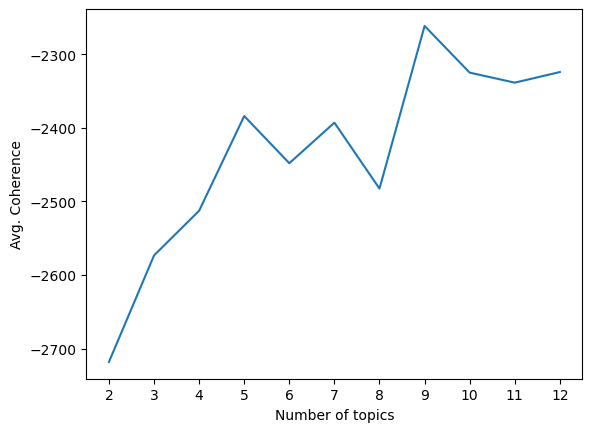

In [ ]:
plt.plot(range(2, 13), avg_coherences)
plt.xlabel('Number of topics')
plt.ylabel('Avg. Coherence')
plt.xticks(range(2, 13))
plt.show()

**It points to 4 topics**

In [13]:
# This allows us to check to which topics woudl tweet number tweet_no, most probably belongs to
def tweet_topic(dataframe, lda, tf, tweet_no):
  tweet_topic_matrix = lda.transform(tf)
  print(f'{dataframe.MESSAGE.iloc[tweet_no]}')
  print(f'{tweet_topic_matrix[tweet_no]}')

In [14]:
# For instance, tweet 14, shown there, belongs to topic 3.
tweet_topic(data_media, lda, tf, 14)

Ohio filed a lawsuit against railroad Norfolk Southern to make sure it pays for the cleanup and environmental damage caused by a fiery train derailment last month. https://t.co/2iybJ3ySje
[0.01803 0.01838 0.94527 0.01832]


**results**

In [133]:
# Sample text
text = [i for i in data_media.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setupt

**Now for government accounts**


In [42]:
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_govt, max_voc = 800, min_df = 2, num_topics = 4)

In [44]:
# Metrics part 1

# 1. Sparsity

sparsity_govt = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_govt}')


Sparsity: 1.496343085106383


In [45]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is update, and it is repeated 3 times in the tweet: update ohioag file civil lawsuit united state district court northern district today full update previous update information


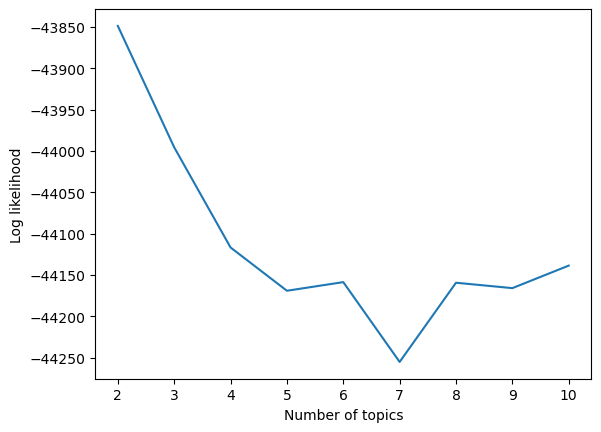

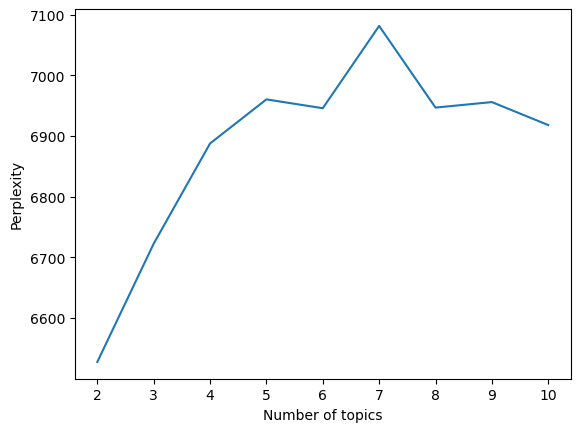

In [62]:
k = 10

text = [i for i in data_govt.T_text]

# Tokenize on bigrams
trigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
trigram_tf = trigram_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in range(2, k+1):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(trigram_tf)
    pipeline = make_pipeline(trigram_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(trigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(trigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

**Coherence**

In [124]:
# Compute coherence

text = [i for i in data_govt.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

In [ ]:
k_values = range(2, 13)
avg_coherences = []
avg_num_unique_words = []

for k in tqdm(k_values):
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(bigram_tokens)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, bigram, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, bigram, False))

100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


In [126]:
avg_num_unique_words_govt = avg_num_unique_words.copy()
avg_coherences_govt = avg_coherences.copy()

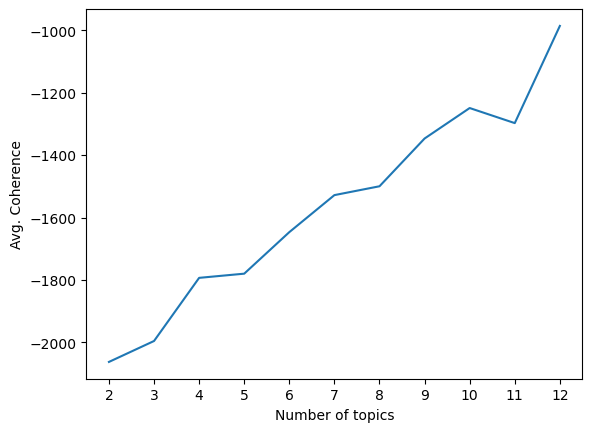

In [127]:
plt.plot(range(2, 13), avg_coherences)
plt.xlabel('Number of topics')
plt.ylabel('Avg. Coherence')
plt.xticks(range(2, 13))
plt.show()

**Government accounts results**

In [129]:
# Sample text
text = [i for i in data_govt.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=2)
lda_model.fit(bigram_tokens)

pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

## People

In [49]:
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_people, 12000, 2, num_topics = 4)

In [51]:
# Metrics part 1

# 1. Sparsity

sparsity_people = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_people}')

Sparsity: 0.09560487099356904


In [52]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is trump, and it is repeated 10 times in the tweet: trump state go trump trump trump trump trump trump trump trump trump


In [53]:
topic_word = np.array([row / row.sum() for row in lda.components_])
topic_word.shape

(4, 12000)

In [56]:
tweet_topic(data_people, lda, tf, 14)

RT @ACTBrigitte Immediately after the train crashed in East Palestine, the Democrats blamed President Trump. 2 weeks later the Washington Post fact checkers found that President Trump's changes had nothing to do with the crash. The Silicon Valley Bank just collapsed and the Democrats are…
[0.01024 0.96866 0.01033 0.01076]


100%|██████████| 11/11 [07:46<00:00, 42.44s/it]


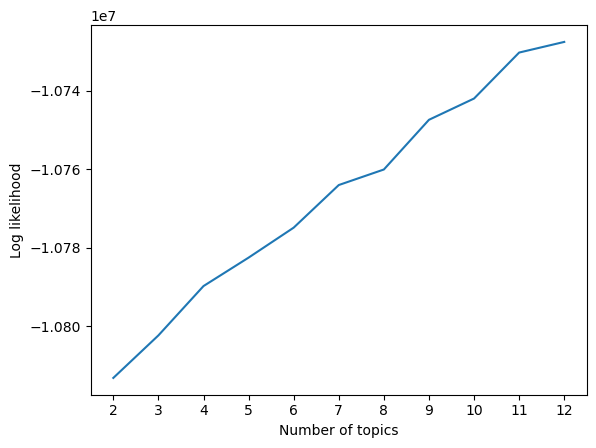

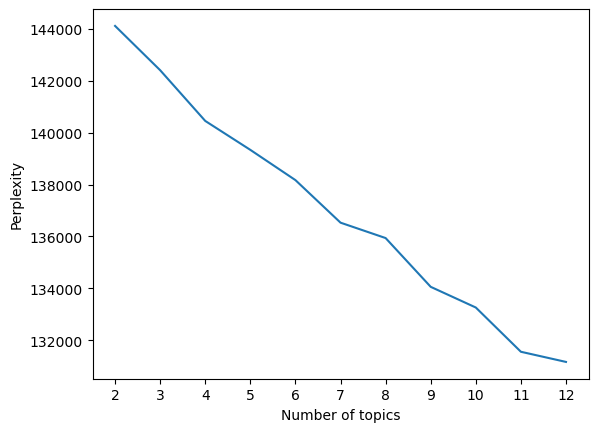

In [115]:
k = 12

text = [i for i in data_people.T_text]

# Tokenize on bigrams
bi_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tf = bi_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in tqdm(range(2, k+1)):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(bigram_tf)
    pipeline = make_pipeline(bi_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(bigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(bigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

**coherence**

In [85]:
# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

In [3]:
compute_average_coherence(topic_word_distributions, num_top_words, bigram, False)

In [98]:
k_values = range(2, 13)
avg_coherences = []
avg_num_unique_words = []

for k in tqdm(k_values):
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(bigram_tokens)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, bigram, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, bigram, False))



100%|██████████| 18/18 [26:01<00:00, 86.76s/it] 


In [118]:
avg_num_unique_words_people = avg_num_unique_words.copy()
avg_coherences_people = avg_coherences.copy()

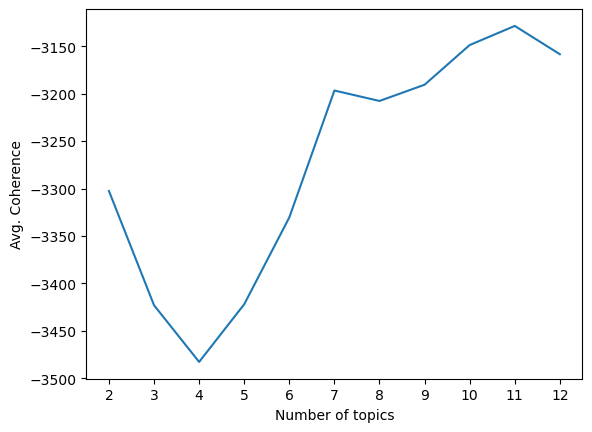

In [112]:
plt.plot(range(2, 13), avg_coherences[0:11])
plt.xlabel('Number of topics')
plt.ylabel('Avg. Coherence')
plt.xticks(range(2, 13))
plt.show()

**Accounts from the public: results**

In [77]:
# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=10)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib

# References
- 95-865 Unstructured Data Analytics by professor George Chen.
- Evaluate Topic Models: Latent Dirichlet Allocation (LDA), available at https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
- Python Machine Learning by Example, Yuxi Liu, Packt Publishing, 2019